# Data Preprocessing Notebook

## 1 Load main results

In [1]:
# main_notebook.ipynb

import geopandas as gpd
import json

# Import the new helper function
from utilities import aggregate_timeseries_vectorized

# --- 1. Load Data ---
# Load the fine-grained mosquito data
gdf = gpd.read_file("data/in/model_output_trentino.geojson")
gdf['timeseries'] = gdf['timeseries'].apply(json.loads)
#gdf["name"] = gdf.index +1
#gdf["name"] = gdf["name"].astype(str).apply(lambda x: f"Cell {x}")
#gdf.head()

# Generate hash from geometry for cells only
import hashlib
from shapely.geometry.polygon import orient
from shapely import set_precision

def make_numeric_hash(geom):
    geom = orient(geom, sign=1.0)              # normalize orientation
    geom = set_precision(geom, grid_size=1e-6) # round coordinates
    geom_bytes = geom.wkb                      # binary form
    hash_val = int(hashlib.md5(geom_bytes).hexdigest(), 16)
    return str(hash_val % 10**10).zfill(10)


gdf["name"] = gdf["geometry"].apply(make_numeric_hash)
gdf

,timeseries,geometry,name
0,"{'15': 0.057999998331069946, '16': 0.050000000...","POLYGON ((10.7 46.5, 10.8 46.5, 10.8 46.4, 10....",9870050411
1,"{'15': 0.057999998331069946, '16': 0.056000001...","POLYGON ((10.8 46.5, 10.9 46.5, 10.9 46.4, 10....",5280222505
2,"{'15': 0.06199999898672104, '16': 0.0619999989...","POLYGON ((10.9 46.5, 11 46.5, 11 46.4, 10.9 46...",6108172358
3,"{'15': 0.07400000095367432, '16': 0.0640000030...","POLYGON ((11 46.5, 11.1 46.5, 11.1 46.4, 11 46...",6239331950
4,"{'15': 0.07800000160932541, '16': 0.0780000016...","POLYGON ((11.1 46.5, 11.2 46.5, 11.2 46.4, 11....",7053904375
...,...,...,...
99,"{'15': 0.10199999809265137, '16': 0.1019999980...","POLYGON ((10.8 45.7, 10.9 45.7, 10.9 45.6, 10....",9720638693
100,"{'15': 0.08799999952316284, '16': 0.0960000008...","POLYGON ((10.9 45.7, 11 45.7, 11 45.6, 10.9 45...",3826578381
101,"{'15': 0.07599999755620956, '16': 0.0879999995...","POLYGON ((11 45.7, 11.1 45.7, 11.1 45.6, 11 45...",5127094061
102,"{'15': 0.07199999690055847, '16': 0.0960000008...","POLYGON ((11.1 45.7, 11.2 45.7, 11.2 45.6, 11....",9541358368


In [2]:
dissolved = gdf.dissolve()  

# drop attributes, keep only geometry
dissolved = dissolved[["geometry"]]

# reset index so it has a clean one-row dataframe
dissolved = dissolved.reset_index(drop=True)
# export to parquet
dissolved.to_parquet("data/in/study_area_extent_trentino.parquet")



In [3]:
gdf.to_file("../public/data/out/model_output_trentino.fgb")

## 2 NUTS3 processing

In [4]:
nuts = gpd.read_file("data/in/EU_NUTS3_01M.fgb")

nuts = aggregate_timeseries_vectorized(
    source_gdf=gdf, 
    target_gdf=nuts, 
    target_id_col='NUTS_ID', # <-- Specify the unique ID column here
    timeseries_col='timeseries'
)

nuts["name"] = nuts["NAME_LATN"]
nuts = nuts[["geometry","timeseries", "name"]]

###########################################################
# quick fix as there are not enough data avilable for other nuts3 regions, delete everything but Trento
nuts.loc[nuts["name"] != "Trento", "timeseries"] = None
###########################################################

nuts.to_file("../public/data/out/EU_NUTS3_01M.fgb")

nuts.loc[nuts['timeseries'].notna()]

Projecting to EPSG:3035 for accurate area calculation...
Performing vectorized spatial overlay...
Calculating weights and grouping results...
Merging results back to target GeoDataFrame...


/Users/dome/work/fem/_webapp_build/data_processing/utilities.py:91: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_series = intersection_gdf.groupby(target_id_col).apply(calculate_weighted_ts)


,geometry,timeseries,name
326,"MULTIPOLYGON (((11.82834 46.50891, 11.81488 46...","{'15': 0.07061623411113074, '16': 0.0784581873...",Trento


## 3 Comuni processing

In [5]:
comuni = gpd.read_file("data/in/IT_comuni.fgb")
# dissolving by COMUNE name probably not a good idea as there are actual correct duplicates. If the data were correct, this code could be used
# comuni = comuni.dissolve(by="COMUNE").reset_index()
# instead, just using a unique id here 

comuni["unique_id"] = comuni.index + 1 # Create a unique ID column if not present

comuni = aggregate_timeseries_vectorized(
    source_gdf=gdf, 
    target_gdf=comuni, 
    target_id_col='unique_id', # <-- Specify the unique ID column here
    timeseries_col='timeseries'
)

del comuni["unique_id"]
comuni["name"] = comuni["COMUNE"]
del comuni["COMUNE"]

comuni.to_file("../public/data/out/IT_comuni.fgb")

comuni.loc[comuni['timeseries'].notna()].head()

Projecting to EPSG:3035 for accurate area calculation...
Performing vectorized spatial overlay...
Calculating weights and grouping results...
Merging results back to target GeoDataFrame...


/Users/dome/work/fem/_webapp_build/data_processing/utilities.py:91: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_series = intersection_gdf.groupby(target_id_col).apply(calculate_weighted_ts)


,geometry,timeseries,name
3637,"MULTIPOLYGON (((11.17721 45.59623, 11.18344 45...","{'15': 0.07199999690055849, '16': 0.0960000008...",Badia Calavena
3639,"MULTIPOLYGON (((11.10433 45.64174, 11.10496 45...","{'15': 0.0736171355235493, '16': 0.09276572358...",Velo Veronese
3640,"MULTIPOLYGON (((11.2121 45.62606, 11.21247 45....","{'15': 0.0766551875670586, '16': 0.10375864423...",Vestenanova
3641,"MULTIPOLYGON (((11.24458 45.59895, 11.24752 45...","{'15': 0.07800000160932541, '16': 0.1059999987...",San Pietro Mussolino
3642,"MULTIPOLYGON (((11.26153 45.61636, 11.26334 45...","{'15': 0.07800000160932541, '16': 0.1059999987...",Altissimo


<Axes: >

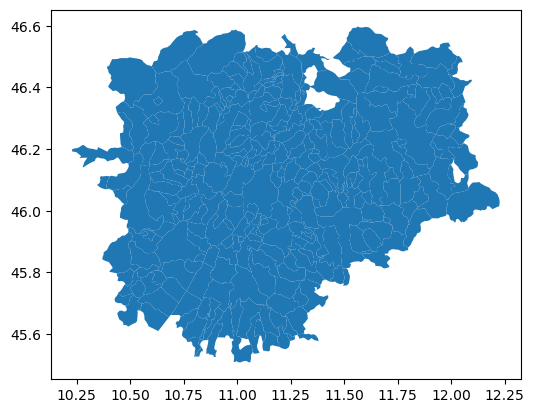

In [6]:
comuni.loc[comuni['timeseries'].notna()].plot()